In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [ ]:
def stochastic_ADAMW(theta, grad=None, gd_params={}, f_params={}):
    '''
    Descenso de Gradiente Adaptable con Momentum y Decaimiento de Peso (AdamW) en versión estocástica
    (se remezclan los datos entre época y época y se usan mini-batches).

    Parámetros
    -----------
    theta     :   vector de parámetros iniciales
    grad      :   función que calcula el gradiente, con firma grad(theta, f_params)
    gd_params :   diccionario con parámetros del algoritmo:
                    - nEpochs    : número de épocas
                    - batch_size : tamaño del mini-batch
                    - alphaADAM  : tamaño de paso (alpha)
                    - eta1       : coeficiente para el primer momento (momentum en la dirección del gradiente, 0 < eta1 < 1)
                    - eta2       : coeficiente para el segundo momento (momentum en el cuadrado del gradiente, 0 < eta2 < 1)
                    - decay      : factor de decaimiento para el peso (decoupled weight decay)
    f_params  :   diccionario con parámetros de la función objetivo:
                    - kappa : parámetro de escala (por ejemplo, para rechazo de outliers)
                    - X     : matriz de variables independientes (datos de entrada)
                    - y     : vector de variables dependientes (etiquetas)

    Regresa
    -----------
    Theta     :   trayectoria de los parámetros. Theta[-1] es el valor final.
    '''
    import numpy as np

    epsilon = 1e-8
    nEpochs    = gd_params['nEpochs']
    batch_size = gd_params['batch_size']
    alpha      = gd_params['alphaADAM']
    eta1       = gd_params['eta1']
    eta2       = gd_params['eta2']
    decay      = gd_params['decay']
    
    X = f_params['X']
    y = f_params['y']
    N = X.shape[0]
    
    Theta = []
    
    # Inicialización de los momentos
    p = np.zeros(theta.shape)
    v = np.zeros(theta.shape)
    
    t_total = 0  # contador global de actualizaciones

    # Entrenamiento por épocas
    for epoch in range(nEpochs):
        # Mezclar aleatoriamente los datos al inicio de cada época
        indices = np.arange(N)
        np.random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        # Iterar sobre mini-batches
        for i in range(0, N, batch_size):
            t_total += 1
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            # Parámetros para la función objetivo con el mini-batch actual
            batch_params = {
                'kappa': f_params['kappa'],
                'X': X_batch,
                'y': y_batch
            }
            
            # Calcular el gradiente usando el mini-batch actual
            g = grad(theta, f_params=batch_params)
            
            # Actualización de los momentos
            p = eta1 * p + (1 - eta1) * g
            v = eta2 * v + (1 - eta2) * (g**2)
            
            # Correcciones de sesgo
            p_hat = p / (1 - (eta1 ** t_total))
            v_hat = v / (1 - (eta2 ** t_total))
            
            # Actualización de parámetros usando AdamW (decaimiento desacoplado)
            theta = theta - alpha * (p_hat / (np.sqrt(v_hat) + epsilon) + decay * theta)
            
            Theta.append(theta.copy())
    
    return np.array(Theta)


# Carga de la base MNIST

In [46]:
mnist = fetch_openml("mnist_784")
X, y = mnist.data, mnist.target.astype(int)

# Separar en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar datos
X_train = X_train / 255.0
X_test  = X_test  / 255.0

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# dimensiones de los conjuntos
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

/home/juancho/.local/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(56000, 784) (56000,)
(14000, 784) (14000,)


# Funcion de activacion

In [17]:
def phi(x):
    return 1/(1+np.exp(-x))
def softmax(x):
    e = np.exp(x - np.max(x))
    return e / e.sum(axis=0)

# Funcion de entrenamiento del modelo

In [41]:
import numpy as np

def phi(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def train_model(X, y, gd_params={}, hidden_size=64, output_size=10, learning_rate=1e-4, epochs=30):
    epsilon = 1e-8
    batch_size = gd_params['batch_size']
    alpha      = gd_params['alphaADAM']
    eta1       = gd_params['eta1']
    eta2       = gd_params['eta2']
    decay      = gd_params['decay']

    input_size = X.shape[1]
    indices = np.arange(X.shape[0])

    np.random.seed(0)  # descomentar si queremos replicar el entrenamiento
    W_1 = 0.1 * np.random.randn(input_size, hidden_size)
    b_1 = 0.1 * np.zeros((1, hidden_size))
    W_2 = 0.1 * np.random.randn(hidden_size, output_size)
    b_2 = 0.1 * np.zeros((1, output_size))

    # Inicialización de los momentos
    p_W1 = np.zeros_like(W_1)
    p_b1 = np.zeros_like(b_1)
    p_W2 = np.zeros_like(W_2)
    p_b2 = np.zeros_like(b_2)
    v_W1 = np.zeros_like(W_1)
    v_b1 = np.zeros_like(b_1)
    v_W2 = np.zeros_like(W_2)
    v_b2 = np.zeros_like(b_2)

    t_total = 0  # contador global de actualizaciones
    Losses = []

    for epoch in range(epochs):
        np.random.shuffle(indices)
        epoch_loss = 0.0
        n_batches = len(indices) // batch_size

        for i in range(0, len(indices), batch_size):
            t_total += 1
            batch_idx = indices[i : i + batch_size]

            X_train = X[batch_idx]
            y_train = y[batch_idx]
            # Codificación one-hot
            y_train_onehot = np.eye(output_size)[y_train]

            # Forward
            y_0 = X_train
            z_1 = y_0 @ W_1 + b_1
            y_1 = phi(z_1)
            z_2 = y_1 @ W_2 + b_2
            y_2 = softmax(z_2)

            # Pérdida de este mini‐batch
            batch_loss = -np.mean(np.sum(y_train_onehot * np.log(y_2 + epsilon), axis=1))
            epoch_loss += batch_loss

            # Backpropagation
            delta_2 = y_2 - y_train_onehot  # derivada de softmax + entropía cruzada
            delta_1 = (delta_2 @ W_2.T) * (y_1 * (1 - y_1))  # derivada sigmoide

            grad_W2 = y_1.T @ delta_2
            grad_b2 = np.sum(delta_2, axis=0, keepdims=True)  # (1, output_size)
            grad_W1 = y_0.T @ delta_1
            grad_b1 = np.sum(delta_1, axis=0, keepdims=True)  # (1, hidden_size)

            # Actualización de los momentos
            p_W1 = eta1 * p_W1 + (1 - eta1) * grad_W1
            p_b1 = eta1 * p_b1 + (1 - eta1) * grad_b1
            p_W2 = eta1 * p_W2 + (1 - eta1) * grad_W2
            p_b2 = eta1 * p_b2 + (1 - eta1) * grad_b2

            v_W1 = eta2 * v_W1 + (1 - eta2) * (grad_W1**2)
            v_b1 = eta2 * v_b1 + (1 - eta2) * (grad_b1**2)
            v_W2 = eta2 * v_W2 + (1 - eta2) * (grad_W2**2)
            v_b2 = eta2 * v_b2 + (1 - eta2) * (grad_b2**2)

            # Correcciones de sesgo
            p_W1_hat = p_W1 / (1 - eta1**t_total)
            p_b1_hat = p_b1 / (1 - eta1**t_total)
            p_W2_hat = p_W2 / (1 - eta1**t_total)
            p_b2_hat = p_b2 / (1 - eta1**t_total)
            v_W1_hat = v_W1 / (1 - eta2**t_total)
            v_b1_hat = v_b1 / (1 - eta2**t_total)
            v_W2_hat = v_W2 / (1 - eta2**t_total)
            v_b2_hat = v_b2 / (1 - eta2**t_total)

            # Actualización de parámetros usando AdamW (decaimiento desacoplado)
            W_1 -= alpha * (p_W1_hat / (np.sqrt(v_W1_hat) + epsilon) + decay * W_1)
            b_1 -= alpha * (p_b1_hat / (np.sqrt(v_b1_hat) + epsilon) + decay * b_1)
            W_2 -= alpha * (p_W2_hat / (np.sqrt(v_W2_hat) + epsilon) + decay * W_2)
            b_2 -= alpha * (p_b2_hat / (np.sqrt(v_b2_hat) + epsilon) + decay * b_2)

        # Pérdida promedio de la época
        epoch_loss /= n_batches
        print(f"Epoch {epoch}, Loss: {epoch_loss}")
        Losses.append([epoch, epoch_loss])

    Losses = np.array(Losses)
    return W_1, b_1, W_2, b_2, Losses

# Prueba

In [42]:
# Parámetros para el algoritmo
gd_params = {'alpha'          : 0.1, 
             'alphaADADELTA'  : 0.7,
             'alphaADAM'      : 0.05,
             'nIter'          : 100,
             'batch_size'     : 200,
             'eta'            : 0.9,
             'eta1'           : 0.9,
             'eta2'           : 0.999,
             'decay'          : 0.01}

In [47]:
W_1, b_1, W_2, b_2, Losses = train_model(X_train, y_train, gd_params)

Epoch 0, Loss: 0.3140495538196017
Epoch 1, Loss: 0.18552078909394842
Epoch 2, Loss: 0.1588816568128242
Epoch 3, Loss: 0.14989503426002113
Epoch 4, Loss: 0.1433401739802839
Epoch 5, Loss: 0.13253924863827846
Epoch 6, Loss: 0.13583082451835415
Epoch 7, Loss: 0.13920990992329385
Epoch 8, Loss: 0.13848870434427302
Epoch 9, Loss: 0.1373837516494971
Epoch 10, Loss: 0.13239066942340433
Epoch 11, Loss: 0.12090984155107766
Epoch 12, Loss: 0.12633744210599337
Epoch 13, Loss: 0.12483098142024193
Epoch 14, Loss: 0.12687017561567202
Epoch 15, Loss: 0.12871814473653506
Epoch 16, Loss: 0.1357553283521728
Epoch 17, Loss: 0.12449951774994923
Epoch 18, Loss: 0.11726481710135549
Epoch 19, Loss: 0.11793358868237286
Epoch 20, Loss: 0.1264653717421178
Epoch 21, Loss: 0.12348992908886999
Epoch 22, Loss: 0.1192853240026653
Epoch 23, Loss: 0.12141040816440327
Epoch 24, Loss: 0.11986682902377058
Epoch 25, Loss: 0.11721908274652375
Epoch 26, Loss: 0.11346880593007042
Epoch 27, Loss: 0.11984184618775603
Epoch 28,

Text(0.5, 1.0, 'Evolución de la pérdida durante entrenamiento')

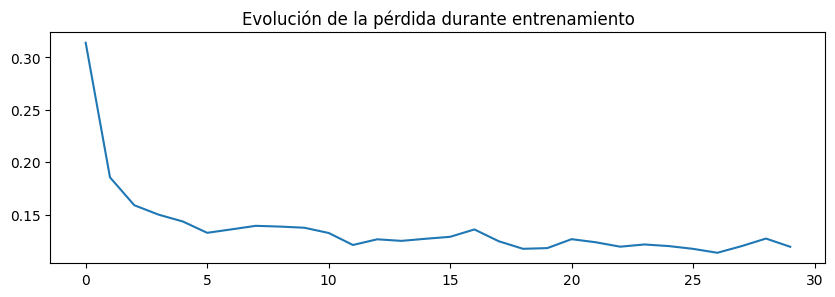

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))
plt.plot(Losses[:,0],Losses[:,1])
plt.title('Evolución de la pérdida durante entrenamiento')

In [49]:
z_1 = X_test @ W_1 + b_1
y_1 = phi(z_1)
z_2 = y_1 @ W_2 + b_2
y_2 = softmax(z_2)

# Predicciones: índice con mayor probabilidad para cada ejemplo
predictions = np.argmax(y_2, axis=1)
y_test = np.array(y_test)

# Calcular Exactitud: porcentaje de clasificaciones correctas
accuracy = np.mean(predictions == y_test)
print(f"Exactitud de Prueba (Test accuracy): {accuracy * 100}%")


Exactitud de Prueba (Test accuracy): 94.87857142857142%
